# Coding seminar Lesson 5 - PyVISA

In this lesson, we control some instrument via Virtual Instrument Software Architecture (VISA).
Procedure is as below:

1. Downlaod and install a VISA driver - so that your PC will recognize what you are connecting to.
2. Install PyVISA - this enables you to handle instrument in your code.
3. Write code and run

## 1. Download and install a VISA driver

To connect your PC with some instrument, you need a VISA driver.
Both [Keysight](https://www.keysight.com/us/en/lib/software-detail/computer-software/io-libraries-suite-downloads-2175637.html) and [National Instrument](https://www.ni.com/en/support/downloads/drivers/download.ni-visa.html#484351) provide the connection suite (including GUI for establishing connection), download your favorite one.

## 2. Install PyVISA

Run below code:
```
pip install pyvisa
```

## 3. Write code and run

Now the environment is ready, let's start coding!

### 1. Check USB address and create a new object for the instrument
First, connect your PC to the instrument and check how it appears in your code.

In [1]:
import pyvisa

rm = pyvisa.ResourceManager()
print(rm.list_resources())

('USB0::0x0471::0x2827::4a::0::INSTR', 'USB0::0x0957::0x8E18::MY51140120::0::INSTR')


This list tells devices that are connected to your PC via USB/LAN by the address.
By checking that, we know the second one is the correct address.

Now, let's create an object for the instrument by specifying the address. Using a query `*IDN?` you can identify what it is.

In [2]:
usb_address, _ = rm.list_resources()
lcr = rm.open_resource(usb_address)
print(lcr.query('*IDN?'))

B&K Precision, 895,480I21101,1.0.5,6.0



Yes, here we have B&K Precision 895 connected.

### 2. Parameter setup

Here we prepare all the parameters. In this example, all condition are as below:

- Run an impedance measurement; measured values are $Z$ and $\phi$ vs. $f$ as shown in Lesson 2.
- Measurement frequencies are from 20 Hz to 1 MHz, in loarithmic manner, for 101 points.
- Amplitude of measurement voltage is 0.1 V.
- DC bias is 0 V.
- No averaging (averaging number is 1)
- aperture is 'medium'
- open correction status is 'off'

Below is how to create input $f$ following the foremat.

In [3]:
import numpy as np

# measurement is from 20 to 1 000 000.
# Obtain log_20(1 000 000) so that we know the range as 20**1 - 20**log_scale
log_scale = np.log(1000000) / np.log(20)

# make 101 points in log scale between 20 to 1 000 000
num_points = 101
freq_ar = np.logspace(1, log_scale, num=num_points, base=20, endpoint=True)
print(freq_ar)

[2.00000000e+01 2.22853621e+01 2.48318683e+01 2.76693588e+01
 3.08310841e+01 3.43540937e+01 3.82796709e+01 4.26538165e+01
 4.75277873e+01 5.29586976e+01 5.90101877e+01 6.57531701e+01
 7.32666604e+01 8.16387030e+01 9.09674030e+01 1.01362076e+02
 1.12944528e+02 1.25850486e+02 1.40231183e+02 1.56255134e+02
 1.74110113e+02 1.94005346e+02 2.16173969e+02 2.40875759e+02
 2.68400176e+02 2.99069756e+02 3.33243891e+02 3.71323040e+02
 4.13753420e+02 4.61032240e+02 5.13713521e+02 5.72414593e+02
 6.37823325e+02 7.10706189e+02 7.91917239e+02 8.82408123e+02
 9.83239228e+02 1.09559211e+03 1.22078335e+03 1.36027995e+03
 1.51571657e+03 1.68891463e+03 1.88190371e+03 2.09694528e+03
 2.33655925e+03 2.60355345e+03 2.90105657e+03 3.23255481e+03
 3.60193273e+03 4.01351876e+03 4.47213595e+03 4.98315846e+03
 5.55257455e+03 6.18705673e+03 6.89403999e+03 7.68180888e+03
 8.55959464e+03 9.53768331e+03 1.06275363e+04 1.18419248e+04
 1.31950791e+04 1.47028558e+04 1.63829233e+04 1.82549689e+04
 2.03409297e+04 2.266524

Remove residual error message from the instrument, if any.

In [4]:
# clear error message
lcr.write(':DISP:CCL')
# clear messages
lcr.write('*CLS')

6

Set to respond to the trigger from PC, to initiate measurement.

In [5]:
# trigger mode BUS mode from USB
lcr.write(':TRIG:SOUR BUS')

16

Now, let's set above condition to the instrument.

In [6]:
# Run an impedance measurement
lcr.write(':FUNC:IMP ZTD')
# automatic measurement range
lcr.write(':FUNC:IMP:RANG:AUTO ON')

# aperture and averaging
lcr.write(':APER MED, 1')

# amplitude
lcr.write(':VOLT 0.1')
# DC bias is zero
lcr.write(':BIAS:STAT OFF')

# open correction status is 'off'
lcr.write(':CORR:OPEN:STAT OFF')

21

Add some more additional parameters...

In [7]:

# set operation status enable register to zero
lcr.write(':STAT:OPER:ENAB 0')
# reset trigger
lcr.write(':ABOR:INIT')

12

Finally, set out a timeout. This sweep takes time like 30 s, and we don't want the machine to abort it.

In [8]:
# timeout for sweep(s) in second
lcr.timeout = 100000

### 3. Run measurement and fetch result

Unfortunately I couldn't find the command to fetch the result of sweep measurement rather than manually insert a USB key and save the result, thus here I repeat single measurement 101 times.

In [9]:
import time

result_array = np.array([])
for fq in freq_ar:
    # input frequency format must be \d.\dE+\d
    freq_string = f'{fq:.1E}'.replace('+0', '+')
    # set frequency
    lcr.write(f':FREQ {freq_string}')

    # trigger
    lcr.write(':TRIG')

    # sleep before fetch
    sleep_time = int(100 / fq) if fq < 100 else 0.5
    time.sleep(sleep_time)

    # fetch
    ar_output = lcr.query_ascii_values('FETC?')
    # append result to array
    print(ar_output)
    result_array = np.append(result_array, ar_output)

[2260040000.0, -55.6239, 0.0]
[4284210000.0, -5.74268, 0.0]
[3778910000.0, -88.5861, 0.0]
[6859020000.0, -179.653, 0.0]
[2226480000.0, -41.742, 0.0]
[1145880000.0, -94.2574, 0.0]
[2781350000.0, -88.8646, 0.0]
[1167800000.0, 97.2698, 0.0]
[813034000.0, 172.822, 0.0]
[1149460000.0, -119.745, 0.0]
[1821790000.0, -102.588, 0.0]
[630629000.0, -70.2147, 0.0]
[766059000.0, -83.5713, 0.0]
[1403340000.0, -90.5026, 0.0]
[29332300000.0, 123.523, 0.0]
[556440000.0, -56.661, 0.0]
[1655310000.0, -99.818, 0.0]
[1085970000.0, -114.13, 0.0]
[1035220000.0, -98.1968, 0.0]
[803747000.0, -71.0805, 0.0]
[824471000.0, -111.128, 0.0]
[908979000.0, -131.304, 0.0]
[707845000.0, -90.3563, 0.0]
[597655000.0, -85.5797, 0.0]
[503941000.0, -86.0407, 0.0]
[549171000.0, -91.2364, 0.0]
[438262000.0, -91.3169, 0.0]
[420279000.0, -85.2013, 0.0]
[361465000.0, -86.5919, 0.0]
[304508000.0, -88.9568, 0.0]
[291953000.0, -92.1898, 0.0]
[260177000.0, -86.7075, 0.0]
[262032000.0, -91.5255, 0.0]
[196855000.0, -88.1522, 0.0]
[1949

In [10]:
reshaped = result_array.reshape(-1, 3)
print(reshaped)

[[ 2.26004e+09 -5.56239e+01  0.00000e+00]
 [ 4.28421e+09 -5.74268e+00  0.00000e+00]
 [ 3.77891e+09 -8.85861e+01  0.00000e+00]
 [ 6.85902e+09 -1.79653e+02  0.00000e+00]
 [ 2.22648e+09 -4.17420e+01  0.00000e+00]
 [ 1.14588e+09 -9.42574e+01  0.00000e+00]
 [ 2.78135e+09 -8.88646e+01  0.00000e+00]
 [ 1.16780e+09  9.72698e+01  0.00000e+00]
 [ 8.13034e+08  1.72822e+02  0.00000e+00]
 [ 1.14946e+09 -1.19745e+02  0.00000e+00]
 [ 1.82179e+09 -1.02588e+02  0.00000e+00]
 [ 6.30629e+08 -7.02147e+01  0.00000e+00]
 [ 7.66059e+08 -8.35713e+01  0.00000e+00]
 [ 1.40334e+09 -9.05026e+01  0.00000e+00]
 [ 2.93323e+10  1.23523e+02  0.00000e+00]
 [ 5.56440e+08 -5.66610e+01  0.00000e+00]
 [ 1.65531e+09 -9.98180e+01  0.00000e+00]
 [ 1.08597e+09 -1.14130e+02  0.00000e+00]
 [ 1.03522e+09 -9.81968e+01  0.00000e+00]
 [ 8.03747e+08 -7.10805e+01  0.00000e+00]
 [ 8.24471e+08 -1.11128e+02  0.00000e+00]
 [ 9.08979e+08 -1.31304e+02  0.00000e+00]
 [ 7.07845e+08 -9.03563e+01  0.00000e+00]
 [ 5.97655e+08 -8.55797e+01  0.000

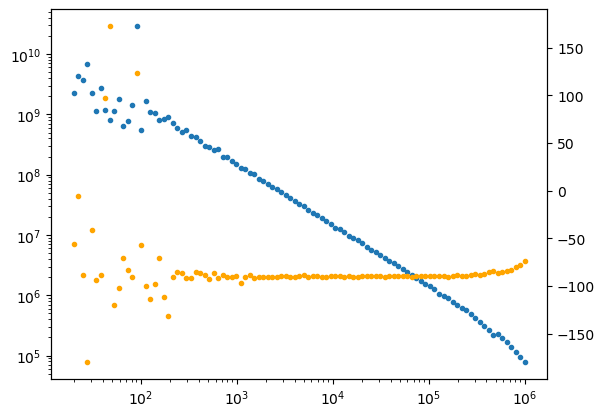

In [11]:
import matplotlib.pyplot as plt
_, ax = plt.subplots()
ax.plot(freq_ar, reshaped[:, 0], '.')
ax.set_xscale('log')
ax.set_yscale('log')
ax2 = ax.twinx()
ax2.plot(freq_ar, reshaped[:, 1], '.', color='orange')

### 4. Post-measurement

Sometimes it happens (to me) but if you don't reset the trigger, the machine continues to output. In case it's high voltage... So don't forget to switch it off!

In [12]:
# change to internal (continuous) trigger
lcr.write(':TRIG:SOUR INT')
lcr.write('*RST')

6